In [1]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv
from matplotlib import pyplot as plt
import cv2
import json
from pathlib import Path
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sn
import pandas as pd
from collections import OrderedDict
from ensemble_boxes import *

In [2]:
carpart_config = '../checkpoints/12_10/carpart/swa_carpart.py'
carpart_checkpoint = '../checkpoints/12_10/carpart/swa_carpart.pth'
carpart_model = init_detector(carpart_config, carpart_checkpoint, device='cuda:0')

/mmdetection/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_local loader


In [3]:
scratch_config = '../checkpoints/12_10/scratch/swa_scratch_pseudo.py'
scratch_checkpoint = '../checkpoints/12_10/scratch/swa_scratch_12_10.pth'
scratch_model = init_detector(scratch_config, scratch_checkpoint, device='cuda:0')

Use load_from_local loader


In [4]:
crack_config = '../checkpoints/combine_crack_phase_1/combine_crack.py'
crack_checkpoint = '../checkpoints/combine_crack_phase_1/epoch_28.pth'
crack_model = init_detector(crack_config, crack_checkpoint, device='cuda:0')

Use load_from_local loader


In [5]:
glass_broken_config = '../checkpoints/windshield/windshield.py'
glass_broken_checkpoint = '../checkpoints/windshield/swa_model_11.pth'
glass_broken_model = init_detector(glass_broken_config, glass_broken_checkpoint, device='cuda:0')

Use load_from_local loader


In [ ]:
#data = Path('/mmdetection/data/cracked_windshield_flickr')
#files = [str(i) for i in data.iterdir() if i.is_file()]
#print(files)
path = Path('/mmdetection/data/windshield/glass_broken')
data = json.load(open(path/'annotations'/'test.json'))
total = json.load(open(path/'annotations'/'total.json'))
print(len(total['annotations']))

In [6]:
carpart_labels = carpart_model.CLASSES
np.random.seed(42)
mask_colors = [
    np.random.randint(0, 256, (1, 3), dtype=np.uint8)
    for _ in range((len(carpart_labels)))
]

def plot_windshield(image,segms,labels):
    for idx,s in enumerate(segms):
        color = mask_colors[labels[idx]]
        color = color.tolist()
        #score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #c = []
        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,list(color[0]),2)
        #image = cv2.putText(image,carpart_labels[labels[idx]],(cx,cy),cv2.FONT_HERSHEY_SIMPLEX,1,list(color[0]),2,cv2.LINE_AA)
    
    return image

def plot_crack(image,segms,labels,scores):
    for idx,s in enumerate(segms):
        #color = 
        #color = mask_colors[labels[idx]]
        #color = color.tolist()
        score = round(scores[idx],2)
        #print(color)
        #print(s)
        
        contours, _ = cv2.findContours(np.array(s).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            continue
            
        c = max(contours,key=cv2.contourArea)
        M = cv2.moments(c)
        if M["m00"] != 0:
            cy = int(M["m01"] / M["m00"])
        else:
            cy = c[0][0][1]
            
        cx = [idi for idi,i in enumerate(s[cy]) if i][0]        
        
        image = cv2.drawContours(image,contours,-1,(255,0,255),2)
        image = cv2.putText(image,str(score)+'|crack |'+str(s.sum()),(cx+10,cy),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    
    return image

In [7]:
def nms_float_fast(dets, thresh):
    """
    # It's different from original nms because we have float coordinates on range [0; 1]
    :param dets: numpy array of boxes with shape: (N, 5). Order: x1, y1, x2, y2, score. All variables in range [0; 1]
    :param thresh: IoU value for boxes
    :return: index of boxes to keep
    """
    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = dets[:, 2]
    y2 = dets[:, 3]
    
    scores = dets[:,4]
    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep = []
    while order.size > 0:
        i = order[0]
        #print(i)
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
       
        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)
        inds = np.where(ovr <= thresh)[0]
        #print(inds)
        #print(order)
        order = order[inds + 1]

    return keep

def check_windshield(segms,labels):
    ws = [(s,l) for idx,(s,l) in enumerate(zip(segms,labels)) if carpart_labels[l] == 'fwi_windshield']
    segms_out = [i[0] for i in ws]
    labels_out = [i[1] for i in ws]
    
    return segms_out,labels_out

#def carpart_inference(model,image,confident_score):
#    result = inference_detector(model,image.copy())
#    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
#    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference(image,confident_score):
    crack_result = inference_detector(crack_model,image.copy())
    scratch_result = inference_detector(scratch_model,image.copy())
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])
    #print('result :',crack_result[0][0])
    h,w = image.shape[:2]
    #print(h,w)
    boxes = crack_result[0][0]
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h
    #print(boxes[:,4])
    #print(boxes)
    keep = nms_float_fast(boxes,0.4)
    #print(keep)
    crack_result[0][0] = boxes[keep]
    #print('segms :',crack_result[1][0])
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def single_model_inference(model,image,confident_score):
    result = inference_detector(model,image.copy())
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(model,image.copy(),result,score_thr=confident_score)
    
    return pred_boxes,pred_segms,pred_labels,pred_scores

def damage_inference_v2(image,crack_confident,scratch_confident):    
    def filter_confident(det_result,confident):
        boxes = det_result[0][0]
        keep = np.where(boxes[:,4] >= confident)[0]
        det_result[0][0] = boxes[keep]
        det_result[1][0] = np.asarray(det_result[1][0])[keep].tolist()
        
        return det_result
    
    crack_result = inference_detector(crack_model,image.copy())
    crack_result = filter_confident(crack_result,crack_confident)
    
    scratch_result = inference_detector(scratch_model,image.copy())
    scratch_result = filter_confident(scratch_result,scratch_confident)
    
    crack_result[0][0] = np.concatenate((crack_result[0][0],scratch_result[0][0]))
    crack_result[1][0].extend(scratch_result[1][0])

    h,w = image.shape[:2]
    boxes = crack_result[0][0]
    
    for idx,b in enumerate(boxes):
        boxes[idx][0] = boxes[idx][0] / w 
        boxes[idx][1] = boxes[idx][1] / h
        boxes[idx][2] = boxes[idx][2] / w
        boxes[idx][3] = boxes[idx][3] / h

    keep = nms_float_fast(boxes,0.3)
    crack_result[0][0] = boxes[keep]
    crack_result[1][0] = np.asarray(crack_result[1][0])[keep].tolist()
    
    out_image,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(crack_model,image.copy(),crack_result,score_thr=0.01)
    
    if pred_segms is None:
        pred_segms = []
    return pred_boxes,pred_segms,pred_labels,pred_scores

def glass_broken_inference(image,confident):
    result = inference_detector(glass_broken_model,image.copy())
    _,pred_boxes,pred_segms,pred_labels,pred_scores = show_result_pyplot(glass_broken_model,image.copy(),result,score_thr=confident)
    
    if pred_segms is None :
        pred_segms = []
    
    return pred_boxes,pred_segms,pred_labels,pred_scores
    
def windshield_inference(image):
    ####### car part inference
    carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    ###### damge inference 
    #boxes,segms,labels,scores = damage_inference_v2(image.copy(),crack_confident=0.64,scratch_confident=0.62)
    boxes,segms,labels,scores = glass_broken_inference(image,confident=0.6)
    ###### post processing
    # check inside windshield
    
    if len(windshield_semgs) > 0 and len(segms) > 0:
        check = [False for _ in range(len(segms))]
        for idx,s in enumerate(segms): 
            if s.sum() == 0:
                continue
            intersect_check = [np.logical_and(s,ws).sum()/s.sum() > 0.7 for ws in windshield_semgs]
            #print(s.sum(),[np.logical_and(s,ws).sum()/s.sum() for ws in windshield_semgs])
            intersect_check = sum(intersect_check) > 0
            check[idx] = intersect_check

        boxes = np.array(boxes)[check]
        #print(len(segms),check)
        segms = segms[check]
        labels = labels[check]
        scores = scores[check]
        
    out = plot_windshield(image,windshield_semgs,windshield_labels)
    out = plot_crack(out,segms,labels,scores)
    
    return out

In [ ]:
'''
image = cv2.imread(files[145])

#damage_inference_v2(image,0.7,0.5)
plt.figure(figsize=(15,10))
show = cv2.cvtColor(np.hstack((image,windshield_inference(image.copy()))),cv2.COLOR_RGB2BGR)
plt.figure(figsize=(15,10))
plt.imshow(show)
'''
i = data['images'][0]
image = cv2.imread(str(path/'images'/i['file_name']))
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==i['id']]
new_image = cv2.drawContours(image.copy(),annos,-1,(255,255,0))
plt.figure(figsize=(15,10))
plt.imshow(new_image)

In [ ]:
out_folder = 'windshield_test'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(data['images']):
    #print(idx)
    img = cv2.imread(str(path/'images'/f['file_name']))
    annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((new_img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f['file_name'],img)

In [ ]:
path = Path('/mmdetection/data/tmp/windshield/instagram')
files = [str(i) for i in path.iterdir() if i.is_file()]
print(files)


out_folder = 'windshield_instagram'
Path(out_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    #annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in data['annotations'] if a['image_id']==f['id']]
    #new_img = cv2.drawContours(img.copy(),annos,-1,(255,0,255))
    img = np.hstack((img,windshield_inference(img.copy())))
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],img)

In [ ]:
s= '/mmdetection/data/tmp/windshield/instagram/119461813_3367613256685024_1741302932519352110_n.jpg'
s[s.rfind('/')+1:]

In [ ]:
# image file name need to be annotate
output = []
out_folder = 'windshield_anno'
Path(out_folder).mkdir(parents=True,exist_ok=True)

no_folder = 'windshield_no'
Path(no_folder).mkdir(parents=True,exist_ok=True)
for f in tqdm(files):
    #print(idx)
    img = cv2.imread(f)
    file_name = f[f.rfind('/')+1:]
    
    carpart_result = single_model_inference(carpart_model,img,0.9)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    boxes,segms,labels,scores = glass_broken_inference(img,confident=0.6)
    
    # model unable to detect any damages -> need to be annotate
    if len(segms) == 0:
        output.append(f)
        
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # damage too large -> no
    areas_check = [s.sum() > 50116.5 for s in segms]
    if sum(areas_check) > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # image from closed distance and it not bigger than 0.4 area of images
    if len(windshield_semgs) == 0:
        area = img.shape[0]*img.shape[1]
        ratios = [s.sum()/area > 0.4  for s in segms]
        check = sum(ratios) == 0
        if check :
            output.append(f)
            cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
            continue
    
    # if there is any damage in windshield and smaller than 0.1*area winshield -> need to be annotate
    main_ws = max(windshield_semgs,key=lambda p:p.sum())
    
    intersect_check = [np.logical_and(s,main_ws).sum() / s.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    size_check = [np.logical_and(s,main_ws).sum() / main_ws.sum() > 0.6 for s in segms if s.sum() > 0 and main_ws.sum() > 0]
    
    # check nothing in main windshield -> potential FP windshield -> need annotation review
    if sum(intersect_check) == 0:
        cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    # check if damage too big -> no
    if np.logical_and(intersect_check,size_check).sum() > 0:
        cv2.imwrite(no_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))
        continue
    
    cv2.imwrite(out_folder+'/'+file_name,cv2.imread('windshield_instagram/'+file_name))

In [ ]:
annos = [np.array(a['segmentation']).reshape(-1,2).astype(np.int32) for a in total['annotations']]
areas = np.array([cv2.contourArea(a) for a in annos])
bound = 1
print(np.quantile(areas,bound))

a,b,c = plt.hist(areas[areas < np.quantile(areas,bound)],bins=100)

In [ ]:
f = '/mmdetection/data/tmp/windshield/instagram/117646015_3084515648441475_7781753156080295698_n.jpg'
image = cv2.imread(f)
#plt.imshow(image)
carpart_result = single_model_inference(carpart_model,image,0.7)
    #print(*carpart_result[1:3])
windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
plt.imshow(windshield_semgs[0])

In [ ]:
contours, _ = cv2.findContours(np.array(windshield_semgs[0]).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img = cv2.drawContours(image.copy(),contours,0,(255,255,0),2)
plt.imshow(img)

center :  [[1791 1173]]
angle :  103.99830686861276
angle :  138.79454906433207
new center :  [[2068 1192]] [[347.31119427  24.17024612]]


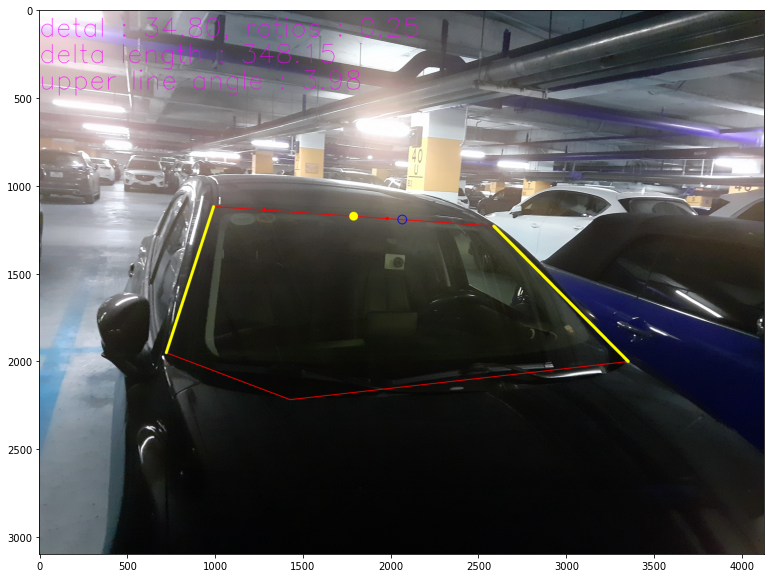

In [53]:
import math
from scipy import spatial


def driver_zone(image,ws_cnt):
    # simplify the contour
    peri = cv2.arcLength(ws_cnt, True)
    approx = cv2.approxPolyDP(ws_cnt, 0.02 * peri, True)
    LEN_APP = len(approx)
    
    # find index of hightest corner of windshield
    def high_of_point(point):
        return point[0][1]
    
    # get upper line (index of highest point + its offset -> upper line)
    #input : contour
    #output : index + offset
    def get_upper_line(cnt):
        len_cnt = len(cnt)
        highest_corner = min(cnt,key=high_of_point) 
        index = [idx for idx,p in enumerate(cnt) if (p == highest_corner).sum() == 2][0]
        
        p1 = cnt[(index+1)%len_cnt]
        p2 = cnt[(index-1)%len_cnt]

        norm_p1 = p1 - cnt[index]
        norm_p2 = p2 - cnt[index]

        tan_p1 = norm_p1[0][1] / norm_p1[0][0]
        tan_p2 = norm_p2[0][1] / norm_p2[0][0]

        ## upline is highest corner and its offset
        if abs(tan_p1) < abs(tan_p2):
            offset = 1
        else:
            offset = -1
        
        return index, offset
    
    def get_angle(a,b,c):
        vector_ba = a-b 
        vector_bc = c-b
        
        cosin = 1 - spatial.distance.cosine(vector_ba,vector_bc)
        
        return math.acos(cosin)
    
    def distance(p1,p2):
        vector_p = p2-p1
        
        return math.sqrt(np.power(vector_p,2).sum()) 
    
    #intersect of two lines p1p2 and p3p4
    #https://answers.opencv.org/question/9511/how-to-find-the-intersection-point-of-two-lines/
    def cross_of_two_lines(p1,p2,p3,p4):
        #print('line 1 ',p1,p2)
        #print('line 2 ',p3,p4)
        x = p3-p1
        d1 = p2-p1
        d2 = p4-p3
        
        cross = d1[0][0]*d2[0][1] - d1[0][1]*d2[0][0]
        
        projection = (x[0][0]*d2[0][1]-x[0][1]*d2[0][0]) / cross
        
        intersect = (p1 + projection*d1).astype(np.int32)
        #print('cross : ',intersect)
        return intersect
    
    # verify exception of upper line 
    ## angle > 150 :
    #### side_len / upper_width > 0.3  -> remove point problem else add point problem
    ## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???
    def verify_upper_line(cnt,index,offset):
        len_cnt = len(cnt)
        upper_width = distance(cnt[index],cnt[(index+offset)%len_cnt])
        new_cnt = cnt.copy()
        
        for zone_id in range(0,2):
            angle = get_angle(approx[(index-offset+zone_id*offset)%len_cnt],approx[(index+zone_id*offset)%len_cnt],
                              approx[(index+offset+zone_id*offset)%len_cnt])
            #print('inside verify angle: ', angle/math.pi*180)
            
            side_point_id = (zone_id == 0)*(index-offset) + (zone_id == 1)*(index+2*offset)
            conern_id = (zone_id == 0)*(index) + (zone_id == 1)*(index+offset)
            
            side_height = distance(cnt[side_point_id%len_cnt],cnt[conern_id%len_cnt])
            
            ## ratio check 
            ratio = side_height/upper_width
            #print('ratio : ',side_height/upper_width)
            
            if angle/math.pi*180 > 150 :
                ## remove conern
                if ratio > 0.4:
                    print('delete problem')
                    new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
                else:    
                    ## add point
                    print('add problem')
                    low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
                    new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                                   cnt[(index+offset)%len_cnt])
                    
                    new_cnt[side_point_id%len_cnt] = new_point
                    new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
                
                return new_cnt,*get_upper_line(new_cnt)
            
            if angle/math.pi*180 > 144 and ratio < 0.4:
                print('add problem')
                low_conern_id = (zone_id == 0)*(index-2*offset) + (zone_id == 1)*(index+3*offset)
                new_point = cross_of_two_lines(cnt[low_conern_id%len_cnt],cnt[side_point_id%len_cnt],cnt[index],
                                               cnt[(index+offset)%len_cnt])

                new_cnt[side_point_id%len_cnt] = new_point
                new_cnt = np.delete(new_cnt,conern_id%len_cnt,0)
                
                return new_cnt,*get_upper_line(new_cnt)
            #side_point = cnt[side_point_id%len_cnt]

            #print('side point : ',side_point)
        
        return cnt,index,offset
    
    
    ## find upper line
    index, offset = get_upper_line(approx)
    approx,index,offset = verify_upper_line(approx,index,offset)
    LEN_APP = len(approx)
    #print('testing output : ',approx,index,offset)
    
    draw_image = cv2.drawContours(image.copy(),[approx],-1,(255,0,0),3)
    #return draw_image, 0
    ## find center upper line
    center = ((approx[index] + approx[(index+offset)%LEN_APP]) / 2).astype(np.int32)\
    #delta = (1 - angles[0]/angles[1])
    print('center : ',center)
    draw_image = cv2.circle(draw_image,center[0],radius=25, color=(255, 255, 0), thickness=-1)
    
    
    
    ## angle of vector1 and vector2 -> find vector2
    def find_vector_from_angle(vector1,angle,vector_check):
        theta = np.power(vector1,2).sum() * math.cos(angle)**2
        a = vector1[0][0]**2 - theta
        b = 2*vector1[0][0]*vector1[0][1]
        c = vector1[0][1]**2 - theta

        result = np.roots([a,b,c])
        
        new_vec1 = np.array([[result[0],1]])
        check1 = abs(1 - spatial.distance.cosine(vector_check,new_vec1))
        new_vec2 = np.array([[result[1],1]])
        check2 = abs(1 - spatial.distance.cosine(vector_check,new_vec2))
        
        #print(check1,check2)
        
        if check1 > check2 :
            return new_vec1
        else:
            return new_vec2
            
    ### find magnitude of adjust_vector to rotate main_vector angle
    def find_adjust_magnitude(adjust_vector,main_vector,adjsut_angle):
        # scalar of adjust_vector and main_vector
        x = (adjust_vector*main_vector).sum()
        
        # power 2 of length adjust_vector
        y = np.power(adjust_vector,2).sum()

        # power 2 of length main_vector
        z = np.power(main_vector,2).sum()
        
        ## quadratic
        a = x**2- math.cos(adjsut_angle)*y*z
        b = 2*x*z-2*math.cos(adjsut_angle)*x*z
        c = z**2 - math.cos(adjsut_angle)*z**2
        
        result = np.roots([a,b,c])
        
        #print(result)
        
        if sum(result > 0) == 1:
            return result[result>0][0]
        else:
            return min(result)
    
    ## input image, contour, start point, projection vector
    ## ouput height of windshield at start point
    def find_windshield_height_at_point(img,cnt,point,projection):
        mask = np.zeros_like(img[:,:,0])
        i_vector = projection / math.sqrt(np.power(projection,2).sum())
        
        contour_mask = cv2.drawContours(mask.copy(),[cnt],-1,1,4)
        line_mask = cv2.line(mask.copy(),(point+10*i_vector).astype(np.int32)[0],
                             (point+max(img.shape[:2])*i_vector).astype(np.int32)[0],1,1)
        
        intersect = np.logical_and(contour_mask,line_mask)
        max_index = np.argmax(intersect)
        intersect_point = np.array([[int(max_index%mask.shape[1]),int(max_index/mask.shape[1])]])

        ws_height = distance(point,intersect_point)
        return ws_height
    
    ## find angle (todo)
    #print('hightest point : ',approx[index], ' other side of upper line : ', approx[index+offset])
    vector = approx[(index+offset)%LEN_APP]-approx[index]
    length_vector = math.sqrt(np.power(vector,2).sum())
    #print('vector : ',vector, 'length : ',length_vector)
    tan = abs(vector[0][1] / vector[0][0])
    
    angles = []
    for zone_id in range(0,2):
        angle = get_angle(approx[(index-offset+zone_id*offset)%LEN_APP],approx[(index+zone_id*offset)%LEN_APP],
                          approx[(index+offset+zone_id*offset)%LEN_APP])
            
        angles.append(angle)
        #draw_image = cv2.putText(draw_image,str(angle/math.pi*180),(0,150*(zone_id+1)),cv2.FONT_HERSHEY_SIMPLEX,5,
        #                         (255,0,255),2, cv2.LINE_AA)
        print('angle : ', angle/math.pi*180)
        
    angles = np.array(angles)
    delta = abs(angles[0] - angles[1])
    camera_angle = math.pi/2 - delta
    delta_length = length_vector*(1/math.sin(camera_angle) - 1)
    adjust_center_vector = vector*((1-angles[0]/angles[1] > 0)*1 - (1-angles[0]/angles[1] <= 0))
    adjust_ratio = 0.8 
    
    if delta/math.pi*180 > 40:
        adjust_ratio = 0.5
    elif delta/math.pi*180 < 20:
        adjust_ratio = 1
        
    new_center = (center + adjust_ratio*adjust_center_vector/length_vector*delta_length).astype(np.int32)
    print('new center : ',new_center,adjust_center_vector/length_vector*delta_length)
    
    draw_image = cv2.circle(draw_image,new_center[0],radius=25, color=(0, 0, 255), thickness=4)
    draw_image = cv2.putText(draw_image,f'detal : {delta/math.pi*180:.2f}, ratios : {1-angles[0]/angles[1]:.2f}',(0,150),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'delta length : {delta_length:.2f}',(0,150*2),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    draw_image = cv2.putText(draw_image,f'upper line angle : {math.atan(vector[0][1]/vector[0][0])/math.pi*180:.2f}',(0,150*3),cv2.FONT_HERSHEY_SIMPLEX,5,
                             (255,0,255),2, cv2.LINE_AA)
    # 2 sides of windshield
    side_vectors = [approx[index] - approx[(index-offset)%LEN_APP],approx[(index+offset)%LEN_APP] - approx[(index+2*offset)%LEN_APP]]
    
    draw_image = cv2.line(draw_image,approx[index][0],approx[(index-offset)%LEN_APP][0],(255,255,0),15)
    draw_image = cv2.line(draw_image,approx[(index+offset)%LEN_APP][0],approx[(index+2*offset)%LEN_APP][0],(255,255,0),15)
    
    #return draw_image, 0 
    pre_image = draw_image.copy()
    
    for zone_id in range(0,2):         
        average_angle = angles[zone_id]
     
        check_vector = side_vectors[zone_id]
        # cos check_vector ,[[1,0]] = 0 -> use check_vector of other side
        cosin_check =  (check_vector*[[1,0]]).sum() / math.sqrt(np.power(check_vector,2).sum())
        #print('cosin check : ',cosin_check)
        if abs(cosin_check) < 0.09:
            v1 = find_vector_from_angle(vector,0.9*angles[1-zone_id],side_vectors[1-zone_id])
        else:
            v1 = find_vector_from_angle(vector,average_angle,check_vector)

        ## find height of windshield
        # find driver zone
        width_zone = 0.2
        start_ratio = 0.18
        prefix_ratio = (zone_id==0)*start_ratio + (zone_id==1)*(1-start_ratio-width_zone)
        
        #projection = prefix_ratio * length_vector / 
        z_point1 = (approx[index] + prefix_ratio*vector).astype(np.int32)
        z_point2 = (approx[index] + (prefix_ratio+width_zone)*vector).astype(np.int32)
        
        draw_image = cv2.circle(draw_image,z_point1[0],radius=10, color=(255, 0, 0), thickness=-1)
    
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,v1)

        projection = (0.6*ws_height/(math.sqrt(np.power(v1,2).sum())))
        projection_vector = projection*v1
        
        ## draw pre adjustion image 
        #pre_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        #pre_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        
        #pre_zone = np.array([z_point1,z_point2,pre_point3,pre_point4])
        #pre_image = cv2.drawContours(pre_image,[pre_zone],-1,(255,255,0),3)
        
        ##? tune this vector : projection*v1 to center
        ## vector from z_point1 -> center
        adjust_vector = center - z_point1
        
        #if average_angle > math.pi/2:
        adjsut_angle = min(abs(average_angle-math.pi/2),abs(average_angle-math.pi))
        adjust_angle = 0.7*adjsut_angle
        
        #print('adjust angle : ',adjust_angle/math.pi*180)
        if abs(cosin_check) < 0.09:
            adjsut_magnitude = 0
        else:
            adjsut_magnitude = find_adjust_magnitude(adjust_vector,projection_vector,adjust_angle)
        projection_vector = projection_vector + adjsut_magnitude*adjust_vector
        leng_projection = math.sqrt(np.power(projection_vector,2).sum())
        
        ws_height = find_windshield_height_at_point(image,approx,z_point1,projection_vector)
        projection_vector = (0.6*ws_height/leng_projection) * projection_vector
        
        z_point3 = np.array(z_point2+projection_vector).astype(np.int32)
        z_point4 = np.array(z_point1+projection_vector).astype(np.int32)
        #print('check : ',distance(z_point1,z_point2),distance(z_point3,z_point4))
        zone = np.array([z_point1,z_point2,z_point3,z_point4])

        #draw_image= cv2.drawContours(draw_image,[zone],-1,(255,255,0),3)

    return draw_image, pre_image

def driver_zone_detection(image):
    ## windshield detection
    carpart_result = single_model_inference(carpart_model,image,0.5)
    windshield_semgs, windshield_labels = check_windshield(*carpart_result[1:3]) 
    
    if len(windshield_semgs) == 0 :
        return image 
    
    ws_segm = max(windshield_semgs,key=lambda x : x.sum())
    contours, _ = cv2.findContours(np.array(ws_segm).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ws_contour = max(contours,key=cv2.contourArea)
    raw_cnt_image = cv2.drawContours(image.copy(),[ws_contour],-1,(255,0,0),3)
    
    ## detect driver zone
    output, pre_image = driver_zone(image,ws_contour)
    
    #result1 = np.hstack([image,raw_cnt_image])
    #result2 = np.hstack([pre_image,output])
    
    #return np.vstack([result1,result2])
    return output

#f = '/mmdetection/data/tmp/windshield/test_pipeline/38.jpg'
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg'
#20211102_202310.jpg
f = '/mmdetection/data/tmp/windshield/real_data/20211102_202310.jpg'
#20211102_202250.jpg
#f = '/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)

plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [ ]:
f = '/mmdetection/data/tmp/windshield/test_pipeline/67929713_1239811336196307_106183138884619112_n.jpg'
image = cv2.imread(f)
out_image = driver_zone_detection(image)
plt.figure(figsize=(15,10))
plt.imshow(out_image)

In [54]:
test_path = Path('/mmdetection/data/tmp/windshield/real_data')
files = [str(i) for i in test_path.iterdir() if i.is_file()]

out_folder = 'windshield_real_data_result'
Path(out_folder).mkdir(parents=True,exist_ok=True)

for f in tqdm(files):
    image = cv2.imread(f)
    print(f)
    out_image = driver_zone_detection(image)
    out_image = cv2.cvtColor(out_image,cv2.COLOR_BGR2RGB)
    cv2.imwrite(out_folder+'/'+f[f.rfind('/')+1:],out_image)


  0%|                                                                                                                                                                         | 0/58 [00:00<?, ?it/s]

/mmdetection/data/tmp/windshield/real_data/20211102_202953.jpg
center :  [[1595 1370]]
angle :  118.54163066087636
angle :  123.59302609795539
new center :  [[1588 1370]] [[-6.97925737  0.37820557]]


  2%|██▊                                                                                                                                                              | 1/58 [00:02<02:03,  2.17s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202214.jpg
center :  [[2044 1232]]
angle :  128.76361747587512
angle :  125.16566108189876
new center :  [[2047 1231]] [[ 3.78988157e+00 -1.97492526e-03]]


  3%|█████▌                                                                                                                                                           | 2/58 [00:04<02:05,  2.24s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202549.jpg
center :  [[1659  987]]
angle :  110.62291379704963
angle :  144.1101971100002
new center :  [[1934 1003]] [[344.51890556  21.09705603]]


  5%|████████▎                                                                                                                                                        | 3/58 [00:08<02:28,  2.69s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203449.jpg
center :  [[1482  870]]
angle :  119.61862333990314
angle :  138.97242057883514
new center :  [[1594  872]] [[112.18224621   2.27598791]]


  7%|███████████                                                                                                                                                      | 4/58 [00:10<02:24,  2.67s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202316.jpg
center :  [[1851 1355]]
angle :  117.26958335982937
angle :  127.49532059439198
new center :  [[1879 1355]] [[28.05203713  0.80702063]]


  9%|█████████████▉                                                                                                                                                   | 5/58 [00:14<02:29,  2.81s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203139.jpg
center :  [[1903 1277]]
angle :  118.45256162869244
angle :  135.86454955900214
new center :  [[1983 1279]] [[80.6302347   2.49718416]]


 10%|████████████████▋                                                                                                                                                | 6/58 [00:17<02:34,  2.96s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201925.jpg
delete problem
center :  [[1898 1124]]
angle :  113.00477611950778
angle :  127.06853587662941
new center :  [[1963 1127]] [[65.63223234  3.21363096]]


 12%|███████████████████▍                                                                                                                                             | 7/58 [00:20<02:30,  2.96s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202522.jpg
center :  [[1346 1556]]
angle :  125.19688470647047
angle :  129.1236063134156
new center :  [[1349 1556]] [[3.60726336 0.07059224]]


 14%|██████████████████████▏                                                                                                                                          | 8/58 [00:23<02:29,  2.98s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202740.jpg
center :  [[2502 1153]]
angle :  110.47629350261252
angle :  131.75324838798062
new center :  [[2428 1154]] [[-91.87484731   1.68242157]]


 16%|████████████████████████▉                                                                                                                                        | 9/58 [00:27<02:42,  3.31s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202909.jpg
center :  [[1997 1559]]
angle :  124.20183249861083
angle :  130.79384558824762
new center :  [[1987 1559]] [[-9.71662295  0.07986265]]


 17%|███████████████████████████▌                                                                                                                                    | 10/58 [00:30<02:37,  3.28s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203052.jpg
center :  [[1421 2381]]
angle :  121.86053582683198
angle :  123.30929686724338
new center :  [[1421 2381]] [[0.42784857 0.01534883]]


 19%|██████████████████████████████▎                                                                                                                                 | 11/58 [00:34<02:38,  3.36s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203301.jpg
add problem
center :  [[1921 1450]]
angle :  107.91419915560846
angle :  139.07535418672322
new center :  [[2173 1465]] [[315.9807822   19.39049624]]


 21%|█████████████████████████████████                                                                                                                               | 12/58 [00:38<02:46,  3.61s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203312.jpg
add problem
center :  [[1485 2075]]
angle :  125.24483978104601
angle :  124.19839596867453
new center :  [[1485 2074]] [[ 0.30642634 -0.00700594]]


 22%|███████████████████████████████████▊                                                                                                                            | 13/58 [00:40<02:26,  3.27s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203221.jpg
add problem
center :  [[1371 2347]]
angle :  117.38760021593475
angle :  134.48397655183433
new center :  [[1445 2351]] [[74.61727989  4.16081486]]


 24%|██████████████████████████████████████▌                                                                                                                         | 14/58 [00:43<02:21,  3.21s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202103.jpg
delete problem
center :  [[2078 1440]]
angle :  111.57938771746298
angle :  126.79190888341932
new center :  [[2021 1440]] [[-56.32188694   0.        ]]


 26%|█████████████████████████████████████████▍                                                                                                                      | 15/58 [00:48<02:30,  3.51s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201850.jpg
center :  [[1402  691]]
angle :  88.37088503342869
angle :  119.12131938985935
new center :  [[1757  695]] [[444.17150369   5.72596782]]


 28%|████████████████████████████████████████████▏                                                                                                                   | 16/58 [00:50<02:11,  3.14s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202620.jpg
center :  [[1662 1316]]
angle :  103.45602646431333
angle :  135.9060604376524
new center :  [[1873 1322]] [[264.03942149   7.95633856]]


 29%|██████████████████████████████████████████████▉                                                                                                                 | 17/58 [00:54<02:16,  3.34s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202109.jpg
delete problem
center :  [[1849 1255]]
angle :  114.26539177119356
angle :  129.5170105215168
new center :  [[1927 1258]] [[78.41456096  3.43154969]]


 31%|█████████████████████████████████████████████████▋                                                                                                              | 18/58 [00:56<02:03,  3.09s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202842.jpg
center :  [[2150 1349]]
angle :  110.43970878175232
angle :  140.42204835182844
new center :  [[1951 1352]] [[-248.27369214    4.4803591 ]]


 33%|████████████████████████████████████████████████████▍                                                                                                           | 19/58 [01:00<02:02,  3.14s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202250.jpg
add problem
center :  [[1993  654]]
angle :  130.06377251698203
angle :  115.27186404681406
new center :  [[1915  653]] [[-77.1563734   -0.10282946]]


 34%|███████████████████████████████████████████████████████▏                                                                                                        | 20/58 [01:03<02:02,  3.22s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202510.jpg
center :  [[1364 1676]]
angle :  130.48445630150508
angle :  120.11402598170841
new center :  [[1388 1675]] [[24.76070346 -0.36534908]]


 36%|█████████████████████████████████████████████████████████▉                                                                                                      | 21/58 [01:07<02:03,  3.34s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203327.jpg
center :  [[1396 1563]]
angle :  116.8352180644751
angle :  134.49858867663573
new center :  [[1462 1577]] [[66.10113849 14.15039342]]


 38%|████████████████████████████████████████████████████████████▋                                                                                                   | 22/58 [01:10<02:01,  3.38s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203001.jpg
delete problem
center :  [[1714 1390]]
angle :  116.07341890785509
angle :  128.17821148078104
new center :  [[1673 1390]] [[-40.70443239   0.40931831]]


 40%|███████████████████████████████████████████████████████████████▍                                                                                                | 23/58 [01:13<01:49,  3.13s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202240.jpg
center :  [[1872  738]]
angle :  125.54214324778472
angle :  132.22435337466896
new center :  [[1857  738]] [[-14.500028     0.37617997]]


 41%|██████████████████████████████████████████████████████████████████▏                                                                                             | 24/58 [01:16<01:48,  3.18s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202434.jpg
center :  [[1966 1215]]
angle :  127.69579310420401
angle :  130.24149191637443
new center :  [[1967 1215]] [[1.89669445 0.06223529]]


 43%|████████████████████████████████████████████████████████████████████▉                                                                                           | 25/58 [01:19<01:39,  3.02s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202606.jpg
delete problem
center :  [[2334 1209]]
angle :  125.61158972161408
angle :  119.55283482699363
new center :  [[2320 1206]] [[-13.54867331  -2.0671276 ]]


 45%|███████████████████████████████████████████████████████████████████████▋                                                                                        | 26/58 [01:21<01:34,  2.96s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202439.jpg
center :  [[2029 1168]]
angle :  118.98664875114136
angle :  132.58936171431566
new center :  [[1980 1168]] [[-48.68623231   0.31745617]]


 47%|██████████████████████████████████████████████████████████████████████████▍                                                                                     | 27/58 [01:24<01:33,  3.02s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201857.jpg
add problem
center :  [[2092 1271]]
angle :  127.86183173038927
angle :  126.8730399671648
new center :  [[2092 1270]] [[ 0.28877934 -0.00327651]]


 48%|█████████████████████████████████████████████████████████████████████████████▏                                                                                  | 28/58 [01:28<01:32,  3.07s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202839.jpg
add problem
center :  [[1704 1302]]
angle :  103.52800860267646
angle :  139.00269927458464
new center :  [[2046 1310]] [[428.5274388   10.25730572]]


 50%|████████████████████████████████████████████████████████████████████████████████                                                                                | 29/58 [01:31<01:34,  3.25s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201845.jpg
center :  [[2045 1085]]
angle :  121.26186042498324
angle :  122.09743733497442
new center :  [[2045 1085]] [[0.2319486  0.00531748]]


 52%|██████████████████████████████████████████████████████████████████████████████████▊                                                                             | 30/58 [01:35<01:30,  3.23s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203402.jpg
center :  [[1750 1280]]
angle :  116.74608137563636
angle :  137.44865984751522
new center :  [[1854 1285]] [[130.05105817   6.62680551]]


 53%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                          | 31/58 [01:38<01:28,  3.26s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203129.jpg
add problem
center :  [[1928  944]]
angle :  104.83319920081998
angle :  132.51040649306123
new center :  [[2060  948]] [[165.38292012   6.0726541 ]]


 55%|████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 32/58 [01:42<01:33,  3.58s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202913.jpg
center :  [[2362 1345]]
angle :  95.07247571870461
angle :  140.89806735938754
new center :  [[2151 1347]] [[-421.98853647    4.78543701]]


 57%|███████████████████████████████████████████████████████████████████████████████████████████                                                                     | 33/58 [01:46<01:32,  3.72s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202327.jpg
delete problem
center :  [[2148 1363]]
angle :  123.61236700352403
angle :  126.91470179717861
new center :  [[2151 1363]] [[3.08041657 0.02827596]]


 59%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                                  | 34/58 [01:50<01:31,  3.79s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203037.jpg
center :  [[1825 1358]]
angle :  123.18570859515972
angle :  133.46312052452018
new center :  [[1848 1358]] [[23.00801068  0.61963459]]


 60%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 35/58 [01:54<01:30,  3.93s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203423.jpg
center :  [[1495  759]]
angle :  94.1487463337171
angle :  136.55688345013758
new center :  [[1860  777]] [[731.38599668  36.4984291 ]]


 62%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 36/58 [01:57<01:14,  3.39s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203249.jpg
center :  [[2047 1593]]
angle :  122.96197615457196
angle :  129.83152876908804
new center :  [[2058 1593]] [[11.52600161  0.20246427]]


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 37/58 [02:00<01:08,  3.25s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202514.jpg
add problem
center :  [[1460 1179]]
angle :  130.61334334995666
angle :  125.89056701693747
new center :  [[1453 1178]] [[-6.29241756 -0.21122355]]


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 38/58 [02:02<01:00,  3.05s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202452.jpg
center :  [[1815 1839]]
angle :  96.69043016711045
angle :  129.88348599030627
new center :  [[1593 1839]] [[-277.07351565    0.58495464]]


 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 39/58 [02:06<01:00,  3.21s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203435.jpg
center :  [[2294 1228]]
angle :  108.5110959212518
angle :  138.68418517974297
new center :  [[2068 1238]] [[-282.25871131   13.47820609]]


 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 40/58 [02:08<00:51,  2.88s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202859.jpg
center :  [[2503 1420]]
angle :  142.36735806295025
angle :  105.15578468146244
new center :  [[2227 1417]] [[-344.8558859    -2.55638166]]


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 41/58 [02:11<00:51,  3.03s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203043.jpg
center :  [[1307 1777]]
angle :  118.81620908235526
angle :  126.60917552652941
new center :  [[1322 1777]] [[15.07302137  0.2703263 ]]


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 42/58 [02:14<00:45,  2.83s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202544.jpg
center :  [[1989 1339]]
angle :  121.66437842446672
angle :  130.68330579483833
new center :  [[2014 1339]] [[25.29919631  0.33799025]]


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 43/58 [02:17<00:46,  3.09s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202305.jpg


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 44/58 [02:19<00:39,  2.82s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203106.jpg
center :  [[1110 2150]]
angle :  121.16314650486987
angle :  110.29359740245778
new center :  [[1136 2149]] [[26.76362336 -0.91343424]]


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 45/58 [02:23<00:41,  3.18s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203330.jpg
center :  [[1731 1580]]
angle :  120.935378238449
angle :  136.04613322153634
new center :  [[1803 1580]] [[7.23097218e+01 3.58146220e-02]]


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 46/58 [02:27<00:37,  3.16s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202310.jpg
center :  [[1791 1173]]
angle :  103.99830686861276
angle :  138.79454906433207
new center :  [[2068 1192]] [[347.31119427  24.17024612]]


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 47/58 [02:30<00:35,  3.23s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203212.jpg
center :  [[1879 1242]]
angle :  111.22200743444343
angle :  134.64915783542472
new center :  [[1985 1247]] [[132.78273463   7.18715749]]


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 48/58 [02:34<00:33,  3.39s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202834.jpg
center :  [[1990 1038]]
angle :  124.26431895697952
angle :  115.68236218749453
new center :  [[1975 1037]] [[-14.75433823  -0.23779056]]


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 49/58 [02:39<00:34,  3.83s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203340.jpg
add problem
center :  [[1847 1390]]
angle :  109.88117981268721
angle :  140.116596667826
new center :  [[2082 1405]] [[294.91515728  19.9969167 ]]


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 50/58 [02:41<00:28,  3.54s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203408.jpg
delete problem
center :  [[1133 1383]]
angle :  107.87297200882504
angle :  131.88937265554785
new center :  [[1240 1398]] [[134.58170223  19.61860025]]


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 51/58 [02:45<00:24,  3.52s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202135.jpg
center :  [[2023 1037]]
angle :  125.73846614690872
angle :  129.5680476787683
new center :  [[2027 1037]] [[4.22287674 0.14322422]]


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 52/58 [02:48<00:20,  3.49s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_201908.jpg
center :  [[2072 1575]]
angle :  126.4206989186049
angle :  131.47464880736644
new center :  [[2079 1575]] [[7.57959435 0.12879846]]


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 53/58 [02:51<00:16,  3.33s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202612.jpg
center :  [[2341 1077]]
angle :  123.57957734457376
angle :  138.33174834971769
new center :  [[2283 1081]] [[-57.81215338   4.4313561 ]]


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 54/58 [02:55<00:13,  3.41s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_203123.jpg
add problem
center :  [[1394 1526]]
angle :  124.13414199767162
angle :  124.92555314934228
new center :  [[1394 1526]] [[0.13241984 0.00095403]]


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 55/58 [02:58<00:10,  3.38s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202854.jpg
center :  [[2042 1529]]
angle :  131.83910244963096
angle :  121.20200125742626
new center :  [[2011 1528]] [[-30.54528919  -0.03496885]]


 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 56/58 [03:02<00:07,  3.62s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202222.jpg
center :  [[1769 1421]]
angle :  117.09167396930515
angle :  131.84778733114268
new center :  [[1828 1425]] [[59.8220874   4.39968602]]


 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 57/58 [03:04<00:03,  3.00s/it]

/mmdetection/data/tmp/windshield/real_data/20211102_202919.jpg
add problem
center :  [[2133 1227]]
angle :  132.35059894925757
angle :  118.7579003560315
new center :  [[2099 1225]] [[-33.19621081  -1.49844007]]


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [03:08<00:00,  3.24s/it]


In [ ]:
## angle > 150 :
    ## side_len / upper_width > 0.3  -> remove point problem else add point problem
## agle > 140 and side_len / upper_width < alpha -> add point problem + alpha = ???


## potential exception 20211102_203408.jpg when side_len / upper_width > 1 -> remove point problem ??? 
#146 144 
#20211102_202606.jpg notable

In [ ]:
## re center problem
#delta angle too big ??? delta > 40 (45.83 20211102_202913.jpg) -> reduce adjustment ratio from 0.9 to 0.5 ???
#delta < 18(20) -> increase adjustment ratio from 0.9 -> 1
# consider angle between upper line and horizontal in formula ??


In [ ]:
## angle of adjustment vector problem
# abs(angle1 - angle2) < 10 : adjust angle = average_angle - 90
# else adjust angle in smaller side = abs(angle - 90), adjust angle in bigger side = 0.5*abs(angle-90) ??